In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Read in data
data = pd.read_csv("Asylum_seekers_per_country_per_year_w_next_year_12_3.csv")

# Create current_population feature
curr_pop_list = []
for index, row in data.iterrows():
    curr_year = str(int(row.Year))
    curr_pop = row[curr_year]
    curr_pop_list.append(curr_pop)
data['current_population']=curr_pop_list

# [Not very useful] Create before_2015 feature
#data['before_2015'] = (data['Year']<2015).astype(int)

# Remove N/A's in Gdelt fields and current_population (these are mismatched countries, bad records anyways)
print(data.shape)
data = data.dropna(subset=['QuadClass','NuMentions'])
print(data.shape)
data = data.dropna(subset=['current_population'])
print(data.shape)
# Remove N/A's in economic data (hopefully we'll fill some of these)
data = data.dropna(subset=['Unemployment Rate',
                           'GDP Per Capita',
                           'Life expectancy',])

data.shape

# S-curve of the current_population variable
num_bins = 100
counts, bin_edges = np.histogram (data.loc[data.current_population<1E8,'current_population'], bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

# Feature engineering

# Log of  Economic Factors: GDP per capita, Unemployment, population
data['log_gdp_per_capita'] = np.log(data['GDP Per Capita']+0.5)
data['log_unemployment'] = np.log(data['Unemployment Rate']+0.1)
data['log_current_population'] = np.log(data['current_population']+1)

# Bucket population
# Less than 4M
data['small_pop'] = list(map(int,data['current_population']<4E6))
# Less than 40M
data['med_pop'] = list(map(int,(data['current_population']<2E7) & (data['current_population']>4E6)))
# More than 20M
data['large_pop'] = list(map(int,data['current_population']>2E7))

# Goldstein Net Counts
data['Goldstein_Net_5'] = data['Goldstein_Pos_5']-data['Goldstein_Neg_5']
data['Goldstein_Net_6'] = data['Goldstein_Pos_6']-data['Goldstein_Neg_6']
data['Goldstein_Net_7'] = data['Goldstein_Pos_7']-data['Goldstein_Neg_7']
data['Goldstein_Net_8'] = data['Goldstein_Pos_8']-data['Goldstein_Neg_8']

# Create y vector, 2000-2017
years = np.arange(2014,2017)
# Tried removing 2014 and 2015, but not very impactful
#years = np.delete(years,[14,15],axis=0)

y = data.loc[data.Year.isin(years),'applied_next_year']

# Log of y, the +0.5 adjustment to avoid ln(0) = -inf
y_ln = np.log(y+0.5)

# Create X feature matrix, including only the columns that we want to predict on in feature_list
feature_list = [
    'Applied during year_x',
    'med_pop',
    'large_pop',
    'GDP Per Capita',
    'log_gdp_per_capita',
    'log_unemployment',
    'Life expectancy',
    'NuMentions',
    'AvgTone',
   'Goldstein_Neg_5',
    'Goldstein_Pos_5',
    'Goldstein_Pos_7',
    'Goldstein_Pos_8',
    'Goldstein_Pos_9',
    'Event_Code_19_20',
    'Extreme_Pos_Tone_Events',
    'Extreme_Neg_Tone_Events'
    ]
X = data.loc[data.Year.isin(years),feature_list]

# Check for columns with N/A's and count the N/A's
for col in X:
    if X[col].isna().any():
        print(col,X[col].value_counts(dropna=False))

# import statsmodels.api as sm

# lm2 = sm.OLS(y_train,X_train)
# results = lm2.fit()
# print(results.summary())

# fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

# ax1 = sm.graphics.influence_plot(results, ax=ax1, criterion="cooks")

# influence = results.get_influence()

# influence.summary_frame()

# Modeling!
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
#import xgboost as xgb

# Normalize X and y
# Note: I'm normalizing (setting mean to 0) not standardizing (setting variance to 1)
transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)

#Train_test_split, post-normalizing
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_ln, test_size=0.2)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_norm)
print(pd.Series([variance_inflation_factor(X_vif, i) 
               for i in range(X_vif.shape[1])]))
print(X_vif[0:2,:])

# Tuning ElasticNet
import itertools

# Function for trying out models
def test_reg_tuning(reg,X_train, X_test, y_train, y_test,l1,alpha,return_reg=False):
    '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
    on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
    reg.fit(X_train,y_train)
    preds = reg.predict(X_test)
    print(l1,alpha,"r^2: ",r2_score(y_test,preds),"\n")
    if return_reg:
        return reg

# Tuning EN_reg
l_1 = [0.1,0.25,0.5,0.75,0.9]
alpha = [0.05,0.1]
for a in alpha:
    for l in l_1:    
        EN_reg = linear_model.ElasticNet(alpha=a,l1_ratio=l)
        test_reg_tuning(EN_reg,X_train, X_test, y_train, y_test,l,a)

# # Tuning GBM
# import itertools

# # Function for trying out models
# def test_reg_tuning(reg,X_train, X_test, y_train, y_test,max_depth,return_reg=False):
#     '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
#     on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
#     reg.fit(X_train,y_train)
#     preds = reg.predict(X_test)
#     print("Learning Rate: ",lr,"N_Estim: ",ne,"r^2: ",r2_score(y_test,preds),"\n")
#     if return_reg:
#         return reg

# # Tuning GB_reg
# #max_depth = [1,2,3,4,5,8,10]
# learning_rate = [0.15,0.1,0.05,0.01,0.005,0.001]
# n_estimators = [100,250,500,750,1000,1250,1500,1750]

# for lr in learning_rate:
#     for ne in n_estimators:
#         GB_reg = ensemble.GradientBoostingRegressor(learning_rate=lr,n_estimators=ne,max_depth=4)
#         test_reg_tuning(GB_reg,X_train, X_test, y_train, y_test,lr,ne)

# Function for trying out models
def test_reg(reg,X_train, X_test, y_train, y_test,return_reg=False):
    '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
    on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
    reg.fit(X_train,y_train)
    preds = reg.predict(X_test)
    print(reg,"\nr^2: ",r2_score(y_test,preds),"\n")
    if return_reg:
        return reg

# Instantiate the regressors
LR_reg = linear_model.LinearRegression()
EN_reg = linear_model.ElasticNet(l1_ratio=0.25,alpha=0.05)
DT_reg = tree.DecisionTreeRegressor()
RF_reg = ensemble.RandomForestRegressor(n_estimators=100)
GB_reg = ensemble.GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=4)
#XGB_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Train and test all models with default settings
for model in [LR_reg,EN_reg,DT_reg,RF_reg,GB_reg]:
    test_reg(model,X_train, X_test, y_train, y_test) 

# Random Forest provides feature_importance...not rock solid, but useful for some context
RF_reg.fit(X_train,y_train)

for name,imp in zip(X.columns,RF_reg.feature_importances_):
    print("{}: {:2.2}".format(name,imp))

'''# Hyperparameter tuning for the RandomForest model
# NOTE: This still isn't working very well.  I'm yet to get a model that beats the defaults.
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = ensemble.RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Make preds and calculate R^2
RF_optimized = best_grid = grid_search.best_estimator_
preds = best_grid.predict(X_test)
print(best_grid,"\nr^2: ",r2_score(y_test,preds),"\n")'''

## Test Data: 2018

In [120]:
# Dependent Variable
y_17 = data.loc[data.Year==2017,'applied_next_year']

y_ln_17 = np.log(y_17+0.5)

# Feature Matrix
X_17 = data.loc[data.Year==2017,feature_list]

transformer_17 = Normalizer().fit(X_17)
X_norm_17 = transformer_17.transform(X_17)


In [121]:
# Predict on 2017
def pred_2017(reg,X_17, y_17):
    '''Takes a trained model and the final test X and test y, in this case 2017 data.'''
    preds = reg.predict(X_17)
    print(reg,"\nr^2: ",r2_score(y_17,preds),"\n")

# Run with best performing model
pred_2017(RF_reg,X_norm_17,y_ln_17)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
r^2:  0.9363554333799975 



### Baseline

In [17]:
# Baseline for 2017
X_baseline = X_norm[:,:1]
X_baseline_17 = X_norm_17[:,:1]

# Instantiate the regressors
LR_reg_baseline = linear_model.LinearRegression()
EN_reg_baseline = linear_model.ElasticNet(l1_ratio=0.25,alpha=0.05)
DT_reg_baseline = tree.DecisionTreeRegressor()
RF_reg_baseline = ensemble.RandomForestRegressor(n_estimators=100)
GB_reg_baseline = ensemble.GradientBoostingRegressor()

# Train and test all models with default settings
for model in [LR_reg_baseline,EN_reg_baseline,DT_reg_baseline,RF_reg_baseline,GB_reg_baseline]:
    test_reg(model,X_baseline, X_baseline_17, y_ln, y_ln_17) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
r^2:  0.3617749927377072 

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.25,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
r^2:  0.3098504061481734 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 
r^2:  0.5983949470138852 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, 

In [18]:
print(X_baseline.shape)
print(X_baseline_17.shape)
print(y_ln.shape)
print(y_ln_17.shape)

(577, 1)
(183, 1)
(577,)
(183,)


//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0.98, 'Skew correction charts for Population, Unemployment, and GDP')

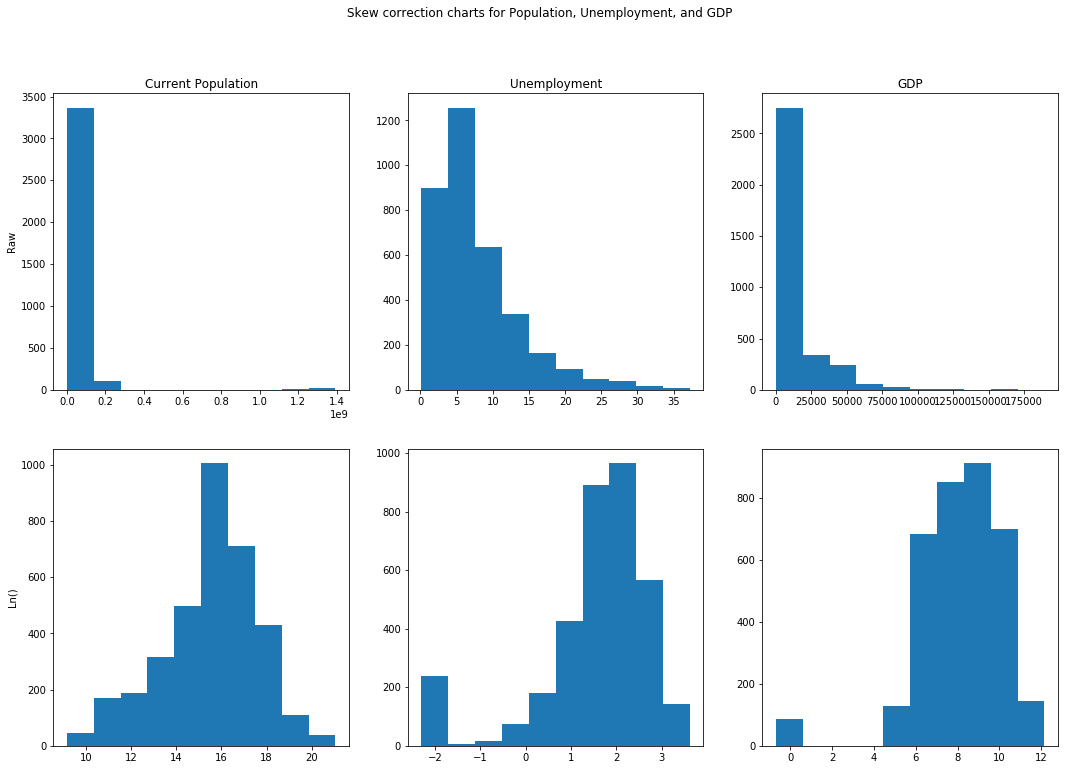

In [19]:
# Skew correction charts for Population, Unemployment, and GDP

fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey=False)
axs[0,0].hist(data['current_population'])
axs[0,1].hist(data['Unemployment (Clean)'])
axs[0,2].hist(data['GDP Per Capita (Clean)'])
axs[1,0].hist(data['log_current_population'])
axs[1,1].hist(data['log_unemployment'])
axs[1,2].hist(data['log_gdp_per_capita'])
axs[0,0].set_title("Current Population")
axs[0,1].set_title("Unemployment")
axs[0,2].set_title("GDP")
axs[0,0].set_ylabel("Raw")
axs[1,0].set_ylabel("Ln()")
fig.suptitle("Skew correction charts for Population, Unemployment, and GDP")

Text(0, 0.5, 'Histogram Number of country-years')

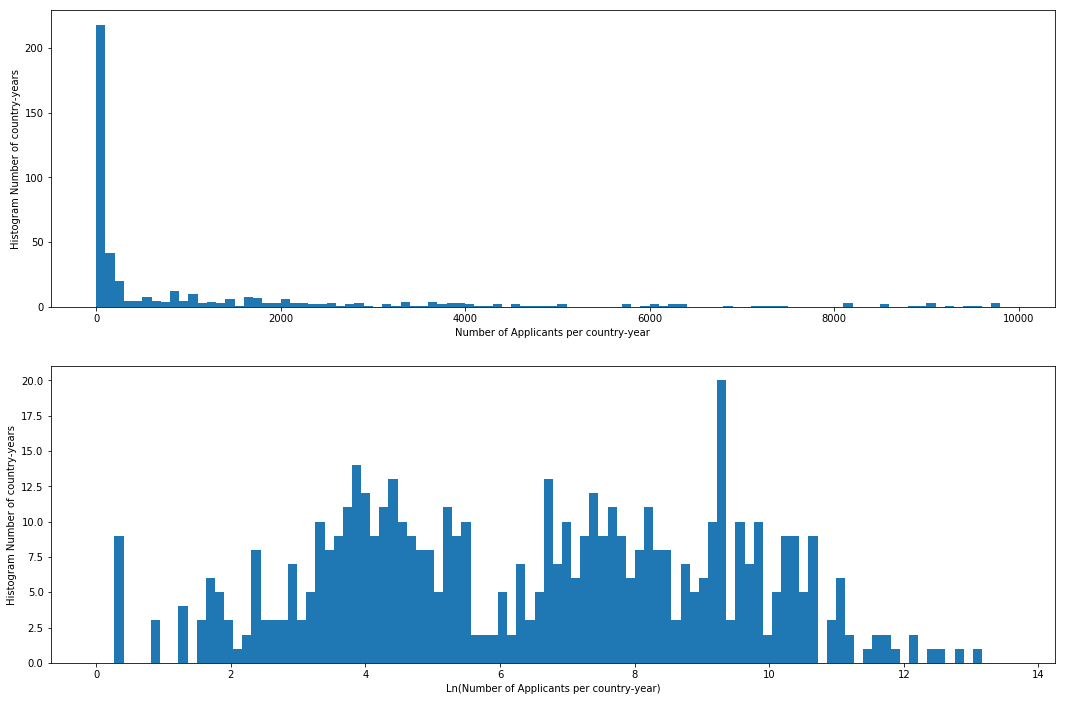

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12), sharey=False)

# Plot the histogram of applicant counts per country-year
bin_arr = np.arange(0,10000,100)
bin_arr_ln = np.arange(0,y_ln.max(),y_ln.max()/100)

axs[0].hist(y,bins=bin_arr)
axs[0].set_xlabel("Number of Applicants per country-year")
axs[0].set_ylabel("Histogram Number of country-years")

axs[1].hist(y_ln,bins=bin_arr_ln)
axs[1].set_xlabel("Ln(Number of Applicants per country-year)")
axs[1].set_ylabel("Histogram Number of country-years")

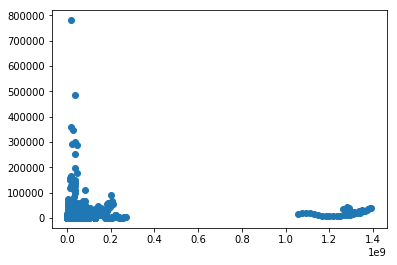

In [21]:
# Applicants - population scatter
plt.scatter(data['current_population'],data['Applied during year_x'])

In [22]:
X_17.columns

Index(['Applied during year_x', 'log_current_population', 'small_pop',
       'med_pop', 'large_pop', 'GDP Per Capita', 'log_gdp_per_capita',
       'log_unemployment', 'Life expectancy', 'GoldsteinScale', 'NuMentions',
       'AvgTone', 'QuadClass', 'Goldstein_Net_5', 'Goldstein_Net_6',
       'Goldstein_Net_7', 'Goldstein_Net_8', 'Goldstein_Neg_5',
       'Goldstein_Neg_6', 'Goldstein_Neg_7', 'Goldstein_Neg_8',
       'Goldstein_Neg_9', 'Goldstein_Pos_5', 'Goldstein_Pos_6',
       'Goldstein_Pos_7', 'Goldstein_Pos_8', 'Goldstein_Pos_9',
       'Quad_4_Goldstein_Neg_5', 'Quad_4_Goldstein_Neg_6',
       'Quad_4_Goldstein_Neg_7', 'Quad_4_Goldstein_Neg_8',
       'Quad_4_Goldstein_Neg_9', 'Event_Code_19_20', 'Extreme_Pos_Tone_Events',
       'Extreme_Neg_Tone_Events'],
      dtype='object')